In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from activations import Cosine
from networks import WHVINetwork
from layers import WHVILinear

In [2]:
torch.manual_seed(0)  # Seed for reproducibility
n = 128  # Number of sampled inputs
x = torch.distributions.Uniform(-1, 2).sample((n,))

# It seems that [-1 + 3/5 * 3, -1 + 3/5 * 4] is the predefined interval for removing 20% of inputs.
x = x[torch.where((x < -1 + 3 / 5 * 3) | (x > -1 + 3 / 5 * 4))]

# It seems that y = f(x) + eps where eps ~ N(0, exp(-3)). The authors do not explicitly say what f is.
# For this reason, we define a similar polynomial and see if we observe a similar pattern.
# The polynomial coefficients are chosen based on observed extrema in the plot.
xs_poly = [-2.0, -1.5, -0.8, 0.0, 0.5, 1.4, 2.0, 2.7, 3.0]
ys_poly = [1.2, 1.5, 2.0, 0.5, -0.5, 1.2, 0.0, 1.0, 1.3]
vmat = np.vander(xs_poly, len(xs_poly))
coef = np.linalg.solve(vmat, ys_poly)

def f(x): return torch.from_numpy(np.polyval(coef, x))
y = f(x) + torch.distributions.Normal(0, np.sqrt(np.exp(-3))).sample((len(x),))

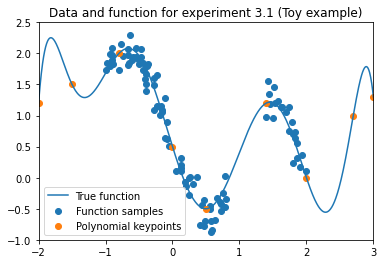

In [3]:
plt.figure()
xs_ls = torch.linspace(-2, 3, 1000)
plt.title('Data and function for experiment 3.1 (Toy example)')
plt.plot(xs_ls, f(xs_ls), label='True function')
plt.scatter(x, y, label='Function samples')
plt.scatter(xs_poly, ys_poly, label='Polynomial keypoints')
plt.ylim(-1, 2.5)
plt.xlim(-2, 3)
plt.legend()
plt.show()

In [4]:
train_x = torch.reshape(x, (-1, 1))
train_y = torch.reshape(y, (-1, 1))
net = WHVINetwork([
    nn.Linear(1, 128),
    Cosine(),
    WHVILinear(128, lambda_=0.01),
    Cosine(),
    WHVILinear(128, lambda_=0.01),
    Cosine(),
    nn.Linear(128, 1)],
    loss_function=F.mse_loss
)
net.train()

gamma=0.0005
p = 0.3
optimizer = optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda t: (1 + gamma * t)**(-p))

In [5]:
for epoch in range(50000):  # Number of epochs not given in paper
    loss = net.loss(train_x, train_y)  # Number of samples not given in paper
    loss.backward()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, loss = {float(loss):.3f}')
    optimizer.step()
    net.zero_grad()

Epoch 0, loss = 437.917
Epoch 100, loss = 412.404
Epoch 200, loss = 387.541
Epoch 300, loss = 362.869
Epoch 400, loss = 338.424
Epoch 500, loss = 314.251
Epoch 600, loss = 290.403
Epoch 700, loss = 266.942
Epoch 800, loss = 243.939
Epoch 900, loss = 221.474
Epoch 1000, loss = 199.640
Epoch 1100, loss = 178.537
Epoch 1200, loss = 158.275
Epoch 1300, loss = 138.969
Epoch 1400, loss = 120.736
Epoch 1500, loss = 103.692
Epoch 1600, loss = 87.939
Epoch 1700, loss = 73.568
Epoch 1800, loss = 60.643
Epoch 1900, loss = 49.200
Epoch 2000, loss = 39.241
Epoch 2100, loss = 30.736
Epoch 2200, loss = 23.618
Epoch 2300, loss = 17.792
Epoch 2400, loss = 13.138
Epoch 2500, loss = 9.519
Epoch 2600, loss = 6.785
Epoch 2700, loss = 4.784
Epoch 2800, loss = 3.370
Epoch 2900, loss = 2.407
Epoch 3000, loss = 1.776
Epoch 3100, loss = 1.379
Epoch 3200, loss = 1.140
Epoch 3300, loss = 1.003
Epoch 3400, loss = 0.927
Epoch 3500, loss = 0.887
Epoch 3600, loss = 0.867
Epoch 3700, loss = 0.857
Epoch 3800, loss = 0.

KeyboardInterrupt: 

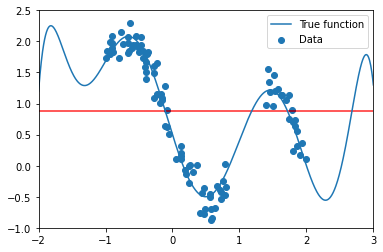

In [6]:
plt.figure()
plt.ylim(-1, 2.5)
plt.xlim(-2, 3)
test_x = torch.reshape(torch.linspace(-2, 3, 1000), (-1, 1))
for _ in range(100):
    out_y = net(test_x)
    plt.plot(test_x.numpy().ravel(), out_y.detach().numpy().ravel(), c='r', alpha=0.01)
plt.plot(xs_ls, f(xs_ls), label='True function')
plt.scatter(x, y, label='Data')
plt.legend()
plt.show()